In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl


In [2]:
# time.sleep(40)

In [3]:
total_count = 48


In [4]:


def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
        if not line.startswith('--') and 'current ops/sec; [UPDATE AverageLatency' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())
            
            print(line,latencies[-1],thputs[-1],times[-1])

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  






def getTimeThps(file, flag):
    
    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)
        
    return np.array(times).astype(float), np.array(thputs).astype(float) 

In [5]:
# os.system("aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")



# os.system("aws --region ap-south-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

In [6]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines, len(lines)

(['13.233.7.235',
  '3.110.188.53',
  '15.207.117.120',
  '3.110.28.84',
  '65.0.107.108',
  '43.204.234.202',
  '52.66.236.170',
  '3.109.121.28',
  '3.108.63.142',
  '15.207.221.92',
  '13.232.156.1',
  '13.233.159.147',
  '65.1.112.85',
  '43.204.235.114',
  '15.207.89.149',
  '13.233.60.45',
  '3.109.122.237',
  '13.232.109.153',
  '3.109.58.37',
  '35.154.223.170',
  '3.109.210.44',
  '35.154.163.148',
  '15.207.249.129',
  '43.204.141.20',
  '13.235.70.220',
  '52.66.248.129',
  '35.154.45.209',
  '13.233.96.203',
  '3.108.249.148',
  '13.127.235.249',
  '65.2.70.187',
  '43.204.212.87',
  '65.1.95.212',
  '43.204.101.113',
  '3.111.39.39',
  '13.233.122.252',
  '65.2.70.117',
  '13.233.115.171',
  '13.233.30.95',
  '65.0.71.74',
  '65.2.142.166',
  '3.7.65.152',
  '13.234.29.126',
  '13.233.69.166',
  '13.232.118.112',
  '65.1.106.227',
  '52.66.113.250',
  '13.127.152.12',
  '15.206.194.146',
  '15.206.179.46',
  '43.204.110.211',
  '65.0.109.191',
  '43.204.141.232',
  '52.66.

In [7]:
for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "FinalKeys.pem" ubuntu@ec2-13-233-7-235.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-110-188-53.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-15-207-117-120.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-110-28-84.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-0-107-108.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-43-204-234-202.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-52-66-236-170.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-109-121-28.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-108-63-142.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-15-207-221-92.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-232-156-1.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-233-159-147.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-1-112-85

In [8]:
## Set number of clusters

nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)




nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

nclients = nclusters

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]



# clientIps = lines[-(nclusters):]
clientIps = lines[-nclients:]



clientIps, no_cluster_yet_nodes

8


(['15.206.194.146',
  '15.206.179.46',
  '43.204.110.211',
  '65.0.109.191',
  '43.204.141.232',
  '52.66.253.81',
  '15.206.209.232',
  '43.204.228.172'],
 [])

In [9]:
## Functions

def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:commands.sh'
        
        print(command)
        os.system(command)
        
def initialize(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
        os.system(command)
        
        
def git_clone(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'
        
        
        os.system(command)
        
def git_pull(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/BftSmart_Final; cd BftSmart_Final; sudo git pull"'
        
        
        os.system(command)
        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo ./gradlew installDist"'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
    rm_command = 'sudo rm config/currentView; '
    for iter_ in range(nclusters):
        rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'
        
        
        os.system(command)
        
        
def clean_all(i):
    ip = lines[i]
    
    rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
        os.system(command)
        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)        
#         print(command)

def check_node(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
        os.system(command)
#         print(command)


def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
        print(command)

In [10]:
# for i in range(len(lines)):
#     run_basic_client_check(i)
    

# def setup(i):

#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
#         os.system(command)
        
# def initialize(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
#         os.system(command)
        
        
# def git_clone(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t " sudo git clone https://tmane002@bitbucket.org/tmane002/BftSmart_Final.git"'
        
        
#         os.system(command)
        
# def git_pull(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/bftsmartt; cd bftsmartt; sudo git pull"'
        
        
#         os.system(command)
        
# def compile_job(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo ./gradlew installDist"'
        
        
#         os.system(command)

        
        
# def clean_job(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; cd bftsmartt; '+rm_command+'"'
        
        
#         os.system(command)
        
        
# def clean_all(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm -r bftsmartt; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
#         os.system(command)
        
# def run_server_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)
        
        
        
#     if ip!='None' and( ip in no_cluster_yet_nodes):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)        
# #         print(command)

# def check_node(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
#         os.system(command)
# #         print(command)


# def run_basic_client(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
# #     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
#         current = (ip.split('.'))
        
# #         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
#         os.system(command)


# def kill_java(i):
#     ip = lines[i]
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)
        
        
        
# def kill_clients(i):
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)

# def run_server_node_check(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         print(command)
        
        

# # for i in range(len(lines)):
# #     run_server_node_check(i)

# def run_basic_client_check(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
#         print(command)

# # for i in range(len(lines)):
# #     run_basic_client_check(i)
    

In [11]:
## First Time Setup

lines, len(lines)

(['13.233.7.235',
  '3.110.188.53',
  '15.207.117.120',
  '3.110.28.84',
  '65.0.107.108',
  '43.204.234.202',
  '52.66.236.170',
  '3.109.121.28',
  '3.108.63.142',
  '15.207.221.92',
  '13.232.156.1',
  '13.233.159.147',
  '65.1.112.85',
  '43.204.235.114',
  '15.207.89.149',
  '13.233.60.45',
  '3.109.122.237',
  '13.232.109.153',
  '3.109.58.37',
  '35.154.223.170',
  '3.109.210.44',
  '35.154.163.148',
  '15.207.249.129',
  '43.204.141.20',
  '13.235.70.220',
  '52.66.248.129',
  '35.154.45.209',
  '13.233.96.203',
  '3.108.249.148',
  '13.127.235.249',
  '65.2.70.187',
  '43.204.212.87',
  '65.1.95.212',
  '43.204.101.113',
  '3.111.39.39',
  '13.233.122.252',
  '65.2.70.117',
  '13.233.115.171',
  '13.233.30.95',
  '65.0.71.74',
  '65.2.142.166',
  '3.7.65.152',
  '13.234.29.126',
  '13.233.69.166',
  '13.232.118.112',
  '65.1.106.227',
  '52.66.113.250',
  '13.127.152.12',
  '15.206.194.146',
  '15.206.179.46',
  '43.204.110.211',
  '65.0.109.191',
  '43.204.141.232',
  '52.66.

In [12]:
# for i in range(10):
#     setup(i)


results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Warning: Permanently added 'ec2-3-110-28-84.ap-south-1.compute.amazonaws.com' (ED25519) to the list of known hosts.
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for 

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [13]:
results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease


Cloning into 'BftSmart_Final'...
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Cloning into 'BftSmart_Final'...


Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
H

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:2 http://ap-south-1.ec2.archiv

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found



                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN            /N-         `NMMy      .m/
  

Reading package lists...Building dependency tree...Building dependency tree...
Building dependency tree...Reading package lists...
Reading state information...


                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`     

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Building dependency tree...Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]

Reading state information...

Reading state information...
Reading package lists...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

Reading state information...

Reading state information...
Reading package lists...
Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

Reading state information...

Reading state information...
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
iputils-ping is already the newest version (3

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 

iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [580 kB]
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Get:4 http://security.ubuntu.

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.


iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]


Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.


Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [142 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.0 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [568 kB]


Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.


Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [89.0 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:14 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [752 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [850 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [208 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.4 kB]
Get:21 http://ap-south-1.ec2

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.


Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [106 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [528 B]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [949 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [204 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [20.7 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [9704 B]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 c-n-f Metadata [476 B]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo

Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [142 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.0 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [568 kB]


fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [89.0 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [752 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [135 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease


fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease


fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Fetched 108 kB in 1s (165 kB/s)
Reading package lists...Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease


fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Fetched 108 kB in 1s (163 kB/s)
Reading package lists...Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease


fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Fetched 108 kB in 1s (158 kB/s)
Reading package lists...Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.c

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Fetched 108 kB in 1s (162 kB/s)
Reading package lists...Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy In

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Fetched 108 kB in 1s (157 kB/s)
Reading package lists...Fetched 108 kB in 1s (160 kB/s)
Reading package lists...Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 http://security.u

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Cloning into 'BftSmart_Final'...
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
hostfile_replace_entries: link /root/.ssh/known_hosts to /root/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /root/.ssh/known_hosts: File exists
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty direct

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:4 http://security.ubuntu.

Building dependency tree...Building dependency tree...

Building dependency tree...Reading package lists...Building dependency tree...

Building dependency tree...
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Building dependency tree...Reading package lists...
Reading state information...
Reading state information...

curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Reading package lists...


Reading state information...
Building dependency tree...
Reading package lists...Reading package lists...Building dependency tree...Reading package lists...build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Reading package lists...

Reading package lists...Building dependency tree...

Reading state information...
Building dependency tree...
Building dependency tree...
Buildin

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh

job.sh: 11: sdk: not found


ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

Reading state information...
Reading package lists...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
            

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Reading package lists...
Building dependency tree...
Reading state information...
Reading package lists...Reading package lists...
Reading state information...


Building dependency tree...Building dependency tree...
Reading state information...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    

job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

Reading state information...
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

Reading state information...

Reading state information...
Reading package lists...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M. 

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.

                                -+syyyyyyys:

                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm 

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found



iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

Reading state information...Reading package lists...

Building dependency tree...Reading package lists...
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:

Reading state information...

Reading state information...Building dependency tree...

              :do`                           .M.       dMMM-     `ms.      /d+` 

job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Reading state information...
Reading package lists...
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading package lists...
Reading state information...
    .NMy                  `:sh+.
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.

Reading state information...

Reading state information...


Reading state information...
Building dependency tree...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Reading package lists...Reading package lists...Reading package lists...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.


Reading state information...

Building dependency tree...Buil

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.


Reading state information...
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Building dependency tree...
Reading state information...
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Reading package lists...
Reading state information...

Reading state information...

Reading package lists...Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Reading package lists...
Building dependency tree...
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Reading package lists...Building dependency t

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Reading state information...

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
iputils-ping is already the newest version (3:202

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Fetched 108 kB in 1s (146 kB/s)
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
Fetched 26.2 MB in 5s (5086 kB/s)
Reading package lists...Fetched 26.2 MB in 5s (5214 kB/s)
Reading package lists...
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .

job.sh: 11: sdk: not found




Reading state information...
Reading package lists...
Building dependency tree...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

Reading state information...
Reading package lists...
Building dependency tree...The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtirpc-dev amd64 1.3.2-2ubuntu0.1 [192 kB]
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev r

Get:43 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg8 amd64 8c-2ubuntu10 [2264 B]
Get:44 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libdeflate0 amd64 1.10-2 [70.9 kB]
Get:45 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libjbig0 amd64 2.1-3.1ubuntu0.22.04.1 [29.2 kB]
Get:46 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libwebp7 amd64 1.2.2-2ubuntu0.22.04.1 [206 kB]
Get:47 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtiff5 amd64 4.3.0-6ubuntu0.4 [183 kB]
Get:48 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libxpm4 amd64 1:3.5.12-1ubuntu0.22.04.1 [36.4 kB]
Get:49 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgd3 amd64 2.3.0-2ubuntu2 [129 kB]
Get:50 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-devtools amd64 2.35-0ubuntu3.1 [28.9 kB]
Get:51 http://ap-south-1.ec2.archive.ubuntu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 63.6 MB in 3s (23.4 MB/s)
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.2 [922 kB]
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:34 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
Get:35 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Fetched 63.6 MB in 4s (16.4 MB/s)
Selecting previously unselected package rpcsvc-proto.
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package libc-dev-bin.
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Selecting previously unselected package libnsl-dev:amd64.
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Selecting previously unselected package gcc-11

Selecting previously unselected package gcc-11.
Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package g++.
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package make.
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Unpacking make (4.3-4.1build1) ...
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Selecting previously unselected package bzip2.
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Unpacking bzip2 (1.0.8-5build1) ...
Selecting previously unselected package lto-disabled-list.
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Unpacking lto-disabled-list (24) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../31-

Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Selecting previously unselected package libjpeg8:amd64.
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously unselected package libdeflate0:amd64.
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Unpacking libdeflate0:amd64 (1.10-2) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up libcc1-0:amd64 (12.1.0-2ubuntu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 484 kB in 1s (852 kB/s)
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

Reading package lists...
Building dependency tree...No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Reading state information...
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl li

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 484 kB in 1s (914 kB/s)
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy        

job.sh: 11: sdk: not found



Reading state information...
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-con

job.sh: 11: sdk: not found



                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN            /N-         `NMMy      .m/
  

Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Fetched 46.3 MB in 14s (3353 kB/s)
Selecting previously unselected package alsa-topology-conf.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Selecting previously unselected package ca-certificates-java.
Preparing to unpack ...

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 46.3 MB in 14s (3253 kB/s)
Selecting previously unselected package alsa-topology-conf.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.2

Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:GTS_Root_R1.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:Certigna.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding de

Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:Certigna.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:Secure_Global_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:GTS_Root_R4.pe

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Running kernel seems to be up-to-date.
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 83 not upgraded.
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


In [14]:
## GIT Clone/Pull



results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such 

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a ter

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [15]:
## Compile Job

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
print(results)  

.....Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
..Starting a Gradle Daemon (subsequent builds will be faster)
.Starting a Gradle Daemon (subsequent builds will be faster)
..Starting a Gradle Daemon (subsequent builds will be faster)
..Starting a Gradle Daemon, 1 stopped Daemon could not be reused, use --status for details
....10%.........10%.............20%...............30%.20%....................40%.30%....................40%.50%....................60%....50%............70%..............60%........80.%........70%.............90%............80%.......100%
........90%...........100%

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html


Welcome to Gradle 7.1!

Here are the highlig

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 

> Task :jar

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@    WARNING: REMOTE HOST IDENTIFICATION HAS CHANGED!     @
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
IT IS POSSIBLE THAT SOMEONE IS DOING SOMETHING NASTY!
Someone could be eavesdropping on you right now (man-in-the-middle attack)!
It is also possible that a host key has just been changed.
The fingerprint for the ED25519 key sent by the remote host is
SHA256:98HkrHXPpCW+/AlI96zpOXpTHl+M8NFodtisIMgyiEk.
Please contact your system administrator.
Add correct host key in /home/tejas/.ssh/known_hosts to get rid of this message.
Offending ECDSA key in /home/tejas/.ssh/known_hosts:557
  remove with:
  ssh-keygen -f "/home/tejas/.ssh/known_hosts" -R "ec2-65-2-70-117.ap-south-1.compute.amazonaws.com"
Password authentication is disabled to avoid man-in-the-middle attacks.
Keyboard-interactive authentication is disabled to avoid man-in-the-middle attacks.
UpdateHostkeys is disabled because the host key is not trusted.


Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent bui

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.

Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.

Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A


> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE

> Task :compileJava
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 

> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :classes

> Task :compileJava
> Task :jar

> Task :compileJava

> Task :compileJava
> Task :jar

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.

Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecat


> Task :compileJava
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :compileJava

> Task :compileJava



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :compileJava
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ub


> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :processResources NO-SOURCE

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist


> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 

> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :compileJava
> Task :classes
BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.




> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :jar
> Task :jar
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCE

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 45s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :jar

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 23s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 24s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 47s
3 actionable tasks: 3 executed
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [16]:
## CLEAN SERVERS

results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: rm: cannot remove 'config7/currentView': No such file or directory
cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove

rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView'rm: cannot remove 'nohup.out': No such file or directory
: No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/cu

rm: rm: cannot remove 'nohup.out': No such file or directory
cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory

rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: ca

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory


In [17]:
## Setup Client and nodeIPS
len(nodeIps), len(clientIps)

(48, 8)

In [18]:
# ## RUN SERVERS

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  

# ### CHECK NODE RESULT

# check_node(7)

# ## Run basic client

# # time.sleep(20)
# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(0)

# time.sleep(60)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

In [19]:
## Main Job

# os.system('git add .; git commit -m "test";git push')

experiment = 'TestRun_tot_'+str(total_count)+'_clusters_'+str(nclusters)

In [20]:
results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 




results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

time.sleep(40)

check_node(7)



print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
time.sleep(100)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': 

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such 

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a ter

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon, 1 stopped Daemon could not be reused, use --status for details
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe opera


> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed


kex_exchange_identification: Connection closed by remote host
Connection closed by 13.127.235.249 port 22


> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@    WARNING: REMOTE HOST IDENTIFICATION HAS CHANGED!     @
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
IT IS POSSIBLE THAT SOMEONE IS DOING SOMETHING NASTY!
Someone could be eavesdropping on you right now (man-in-the-middle attack)!
It is also possible that a host key has just been changed.
The fingerprint for the ED25519 key sent by the remote host is
SHA256:98HkrHXPpCW+/AlI96zpOXpTHl+M8NFodtisIMgyiEk.
Please contact your system administrator.
Add correct host key in /home/tejas/.ssh/known_hosts to get rid of this message.
Offending ECDSA key in /home/tejas/.ssh/known_hosts:557
  remove with:
  ssh-keygen -f "/home/tejas/.ssh/known_hosts" -R "ec2-65-2-70-117.ap-south-1.compute.amazonaws.com"
Password authentication is disabled to avoid man-in-the-middle attacks.
Keyboard-interactive authentication is disabled to avoid man-in-the-middle attacks.
UpdateHostkeys is disabled because the host key is not trusted.


Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent bui

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.

Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.




> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar

> Task :compileJava
> Task :jar
> Task :jar

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A


> Task :compileJava

> Task :compileJava

> Task :compileJava
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :installDist

> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava
BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A


> Task :compileJava
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.

Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.

Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated

> Task :jar

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :compileJava
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar


Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:unchecked for details.Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompil


> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar

> Task :compileJava
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 

> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed


> Task :processResources NO-SOURCE
> Task :classes
> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :ins

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 22

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config1/currentView'rm: cannot remove 'config3/currentView': No such file or directory
: No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView

rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directoryrm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory

rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: can

rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config7/currentView'rm: cannot remove 'config3/currentView': No such file or directory
: No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: ca

XXXXXXXX Started Servers XXXXXXXXXXXX
XXXXXXXX Started Clients XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) are: 11071, /172.31.15.92
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 0
-- Getting connection for remoteId: 0
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@740773a3
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 1
-- Getting connection for remoteId: 1
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@2f54a33d
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 2
-- Getting connec

-- Getting connection for ret: bftsmart.communication.server.ServerConnection@343570b7, remoteId: 11
-- dudud Trying establish connection with Replica: 19, Socket[addr=/172.31.13.209,port=44184,localport=11071], /172.31.15.92
-- this.controller.getStaticConf().getTTPId(),remoteId, this.controller.isCurrentViewMember(remoteId) are 7002, 19, false 
-- ReConnecting with replica inside establishConnection: 19
-- Getting connection for ret: bftsmart.communication.server.ServerConnection@574b560f, remoteId: 6
-- Sent CID reply to replica 6 with ID 0
-- dudud Trying establish connection with Replica: 21, Socket[addr=/172.31.5.203,port=46426,localport=11071], /172.31.15.92
-- this.controller.getStaticConf().getTTPId(),remoteId, this.controller.isCurrentViewMember(remoteId) are 7002, 21, false 
-- ReConnecting with replica inside establishConnection: 21
-- dudud Trying establish connection with Replica: 36, Socket[addr=/172.31.3.20,port=48386,localport=11071], /172.31.15.92
-- this.controller.g

nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@    WARNING: REMOTE HOST IDENTIFICATION HAS CHANGED!     @
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
IT IS POSSIBLE THAT SOMEONE IS DOING SOMETHING NASTY!
Someone could be eavesdropping on you right now (man-in-the-middle attack)!
It is also possible that a host key has just been changed.
The fingerprint for the ED25519 key sent by the remote host is
SHA256:98HkrHXPpCW+/AlI96zpOXpTHl+M8NFodtisIMgyiEk.
Please contact your system administrator.
Add correct host key in /home/tejas/.ssh/known_hosts to get rid of this message.
Offending ECDSA key in /home/tejas/.ssh/known_hosts:557
  remove with:
  ssh-keygen -f "/home/tejas/.ssh/known_hosts" -R "ec2-65-2-70-117.ap-south-1.compute.amazonaws.com"
Password authentication is disabled to avoid man-in-the-middle attacks.
Keybo

In [21]:
if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

for ip in nodeIps[:1]:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
#         print(command)
        os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
        print(command)
        os.system(command)

rm: cannot remove 'TestRun_tot_48_clusters_8.png': No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory


scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-15-206-194-146.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/TestRun_tot_48_clusters_8/nohup_client_48.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-15-206-179-46.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/TestRun_tot_48_clusters_8/nohup_client_49.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-43-204-110-211.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/TestRun_tot_48_clusters_8/nohup_client_50.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-65-0-109-191.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/TestRun_tot_48_clusters_8/nohup_client_51.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-43-204-141-232.ap-south-1.compute.amazonaws.com:/home/ubuntu/n

 8 sec: 100 operations; 99.9 current ops/sec; [UPDATE AverageLatency(us)=2219044.13] 
 2219044.13 99.9 8
 9 sec: 200 operations; 99.8 current ops/sec; [UPDATE AverageLatency(us)=1329766.04] 
 1329766.04 99.8 9
 10 sec: 300 operations; 99.9 current ops/sec; [UPDATE AverageLatency(us)=982360.91] 
 982360.91 99.9 10
 11 sec: 400 operations; 100 current ops/sec; [UPDATE AverageLatency(us)=754433.2] 
 754433.2 100 11
 12 sec: 500 operations; 99.9 current ops/sec; [UPDATE AverageLatency(us)=949033.48] 
 949033.48 99.9 12
 13 sec: 600 operations; 99.9 current ops/sec; [UPDATE AverageLatency(us)=918889.12] 
 918889.12 99.9 13
 14 sec: 700 operations; 99.9 current ops/sec; [UPDATE AverageLatency(us)=1287279.31] 
 1287279.31 99.9 14
 15 sec: 800 operations; 99.9 current ops/sec; [UPDATE AverageLatency(us)=485033.44] 
 485033.44 99.9 15
 16 sec: 997 operations; 197 current ops/sec; [UPDATE AverageLatency(us)=804963.03] 
 804963.03 197 16
 17 sec: 1000 operations; 3 current ops/sec; [UPDATE Averag

 500545.99 199.8 43
 44 sec: 4171 operations; 164 current ops/sec; [UPDATE AverageLatency(us)=631289.66] 
 631289.66 164 44
 45 sec: 4271 operations; 99.9 current ops/sec; [UPDATE AverageLatency(us)=564820.34] 
 564820.34 99.9 45
 46 sec: 4407 operations; 135.86 current ops/sec; [UPDATE AverageLatency(us)=952278.38] 
 952278.38 135.86 46
 47 sec: 4571 operations; 164 current ops/sec; [UPDATE AverageLatency(us)=726120.38] 
 726120.38 164 47
 48 sec: 4670 operations; 98.9 current ops/sec; [UPDATE AverageLatency(us)=740154.25] 
 740154.25 98.9 48
 49 sec: 4771 operations; 101 current ops/sec; [UPDATE AverageLatency(us)=852478.68] 
 852478.68 101 49
 50 sec: 4970 operations; 198.6 current ops/sec; [UPDATE AverageLatency(us)=794100.43] 
 794100.43 198.6 50
 51 sec: 5070 operations; 100 current ops/sec; [UPDATE AverageLatency(us)=689635.28] 
 689635.28 100 51
 52 sec: 5264 operations; 193.81 current ops/sec; [UPDATE AverageLatency(us)=637821.44] 
 637821.44 193.81 52
 53 sec: 5371 operations

 845350.99 180 43
 44 sec: 4065 operations; 291 current ops/sec; [UPDATE AverageLatency(us)=364818.82] 
 364818.82 291 44
 45 sec: 4265 operations; 199.8 current ops/sec; [UPDATE AverageLatency(us)=487908.21] 
 487908.21 199.8 45
 46 sec: 4391 operations; 126 current ops/sec; [UPDATE AverageLatency(us)=579772.63] 
 579772.63 126 46
 47 sec: 4591 operations; 199.8 current ops/sec; [UPDATE AverageLatency(us)=678141.12] 
 678141.12 199.8 47
 48 sec: 4764 operations; 172.83 current ops/sec; [UPDATE AverageLatency(us)=528078.65] 
 528078.65 172.83 48
 49 sec: 4887 operations; 122.75 current ops/sec; [UPDATE AverageLatency(us)=747662.19] 
 747662.19 122.75 49
 50 sec: 4987 operations; 100 current ops/sec; [UPDATE AverageLatency(us)=669518.37] 
 669518.37 100 50
 51 sec: 5162 operations; 174.83 current ops/sec; [UPDATE AverageLatency(us)=754521.96] 
 754521.96 174.83 51
 52 sec: 5346 operations; 184 current ops/sec; [UPDATE AverageLatency(us)=632731.71] 
 632731.71 184 52
 53 sec: 5464 operat

 61 sec: 5013 operations; 177 current ops/sec; [UPDATE AverageLatency(us)=623982.24] 
 623982.24 177 61
 62 sec: 5236 operations; 222.78 current ops/sec; [UPDATE AverageLatency(us)=520408.89] 
 520408.89 222.78 62
 63 sec: 5368 operations; 132 current ops/sec; [UPDATE AverageLatency(us)=675635.55] 
 675635.55 132 63
 64 sec: 5508 operations; 140 current ops/sec; [UPDATE AverageLatency(us)=805428.46] 
 805428.46 140 64
 65 sec: 5613 operations; 104.79 current ops/sec; [UPDATE AverageLatency(us)=763621.66] 
 763621.66 104.79 65
 66 sec: 5713 operations; 100 current ops/sec; [UPDATE AverageLatency(us)=896751.01] 
 896751.01 100 66
 67 sec: 5836 operations; 123 current ops/sec; [UPDATE AverageLatency(us)=899186.5] 
 899186.5 123 67
 68 sec: 5913 operations; 76.92 current ops/sec; [UPDATE AverageLatency(us)=802565.21] 
 802565.21 76.92 68
 69 sec: 6008 operations; 95 current ops/sec; [UPDATE AverageLatency(us)=1339542.16] 
 1339542.16 95 69
 70 sec: 6107 operations; 98.8 current ops/sec; [U

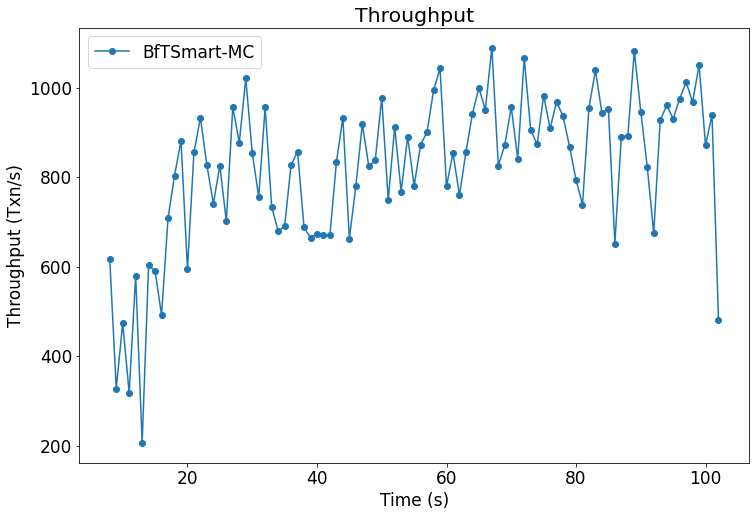

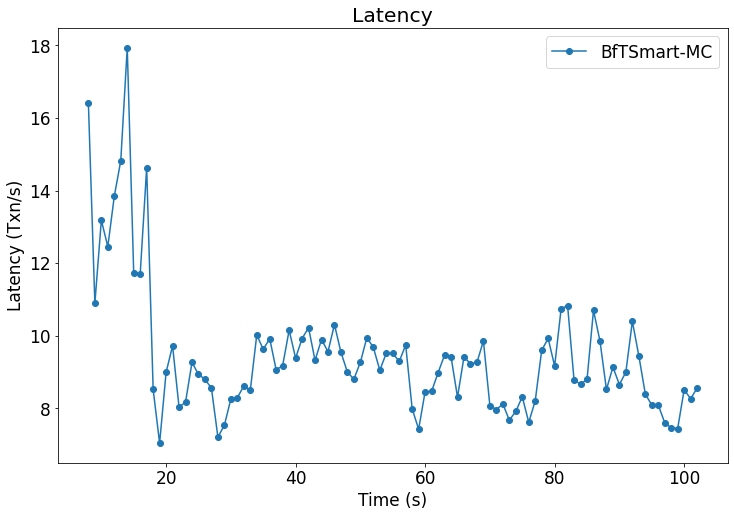

In [22]:
times_thputsDict = {}
times_latsDict = {}

for ip in clientIps[:1]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        times_thputsDict[times[i]] = thputs[i]
        times_latsDict[times[i]] = lats[i]
        

for ip in clientIps[1:]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        
        if times[i] in times_thputsDict.keys():
            times_thputsDict[times[i]] += thputs[i]
            
        if times[i] in times_latsDict.keys():
            times_latsDict[times[i]] += lats[i]
    

PIK = '../Experiments/'+experiment+"/pickle.dat"

data = [times_thputsDict, times_latsDict]

with open(PIK, "wb") as f:
    pickle.dump(data, f)


data2 = []
with open(PIK, "rb") as f:
    data2 =  pickle.load(f)


dict1 = data2[0]
dict2 = data2[1]



times1 = np.array(list(dict1.keys()))
thputs = np.array(list(dict1.values()))

times2 = np.array(list(dict2.keys()))
lats = np.array(list(dict2.values()))

times1

import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
pl.show()




pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], lats[:], '-o', label='BfTSmart-MC')


pl.title(r'Latency')


pl.xlabel('Time (s)')
pl.ylabel('Latency (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
pl.show()

In [23]:
lats, np.average(lats[-35:-5])

(array([16.40756102, 10.89350761, 13.1820104 , 12.45694009, 13.84267352,
        14.82139846, 17.93433541, 11.73019115, 11.70055947, 14.62786811,
         8.52340111,  7.04776405,  8.99339505,  9.72444392,  8.03574574,
         8.17477168,  9.26678431,  8.94010769,  8.8019379 ,  8.55925649,
         7.21099326,  7.53870334,  8.25796977,  8.29640235,  8.61748471,
         8.49738359, 10.02245135,  9.63012788,  9.91980358,  9.0628421 ,
         9.18013756, 10.15402935,  9.38701014,  9.92592888, 10.22154421,
         9.32633963,  9.89547055,  9.56497668, 10.3083375 ,  9.54702151,
         9.000125  ,  8.80774806,  9.2724341 ,  9.94774538,  9.6830084 ,
         9.05425567,  9.5194387 ,  9.51725246,  9.29600926,  9.74451852,
         7.98856553,  7.42847313,  8.46419981,  8.47105267,  8.98393338,
         9.46754563,  9.42513999,  8.31091221,  9.41800141,  9.23270114,
         9.26565546,  9.85780771,  8.07493447,  7.96889469,  8.12470596,
         7.67839027,  7.91860707,  8.32092871,  7.6

In [24]:
np.sum(thputs),  np.average(thputs[-35:-5])

(78050.47999999998, 906.2729999999999)

In [25]:
# np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

In [26]:
# ## Main Job

# # os.system('git add .; git commit -m "test";git push')

# experiment = 'RemoveViewChangeBftSmartMC'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(125)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
#         print(command)
#         os.system(command)

# times_thputsDict = {}
# times_latsDict = {}

# for ip in clientIps[:1]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
#         times_thputsDict[times[i]] = thputs[i]
#         times_latsDict[times[i]] = lats[i]
        

# for ip in clientIps[1:]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
        
#         if times[i] in times_thputsDict.keys():
#             times_thputsDict[times[i]] += thputs[i]
            
#         if times[i] in times_latsDict.keys():
#             times_latsDict[times[i]] += lats[i]
    

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data = [times_thputsDict, times_latsDict]

# with open(PIK, "wb") as f:
#     pickle.dump(data, f)


# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1


# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Remote View Change for BftSmart-MC with timeout = 20 s')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [27]:
# ## Main Job

# # os.system('git add .; git commit -m "test";git push')

# experiment = 'NonLeaderFailure'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(85)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in [3])
# time.sleep(45)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
#         print(command)
#         os.system(command)

# times_thputsDict = {}
# times_latsDict = {}

# for ip in clientIps[:1]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
#         times_thputsDict[times[i]] = thputs[i]
#         times_latsDict[times[i]] = lats[i]
        

# for ip in clientIps[1:]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
        
#         if times[i] in times_thputsDict.keys():
#             times_thputsDict[times[i]] += thputs[i]
            
#         if times[i] in times_latsDict.keys():
#             times_latsDict[times[i]] += lats[i]
    

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data = [times_thputsDict, times_latsDict]

# with open(PIK, "wb") as f:
#     pickle.dump(data, f)


# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [28]:
# experiment = 'NonLeaderFailure'

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')
# pl.axvline(x=85.48, ls='--', color = 'red')

# pl.title(r'Throughput')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [29]:
# ## Main Job

# # os.system('git add .; git commit -m "test";git push')

# experiment = 'LeaderFailure'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(85)

# # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in [0])
# time.sleep(100)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
#         print(command)
#         os.system(command)

# times_thputsDict = {}
# times_latsDict = {}

# for ip in clientIps[:1]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
#         times_thputsDict[times[i]] = thputs[i]
#         times_latsDict[times[i]] = lats[i]
        

# for ip in clientIps[1:]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
        
#         if times[i] in times_thputsDict.keys():
#             times_thputsDict[times[i]] += thputs[i]
            
#         if times[i] in times_latsDict.keys():
#             times_latsDict[times[i]] += lats[i]
    

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data = [times_thputsDict, times_latsDict]

# with open(PIK, "wb") as f:
#     pickle.dump(data, f)


# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [30]:

# def join_node1(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.24.233 11080 11081 config0 >../nohup_j1.out 2>&1 &"'
        
        
#         os.system(command)   
        
        
# def join_node2(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 172.31.19.58 11090 11091 config0 >../nohup_j2.out 2>&1 &"'
        
        
#         os.system(command)
        
        
# def join_node3(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 10 172.31.29.208 11100 11101 config0 >../nohup_j1.out 2>&1 &"'
        
        
#         os.system(command)   
        
        
# def join_node4(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 11 172.31.25.228 11110 11111 1 config1 >../nohup_j2.out 2>&1 &"'
        
        
#         os.system(command)           

# # join_node1(11), join_node2(11)

# # time.sleep(30)
# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(45)
# # print(results)  

# # time.sleep(45)
# # join_node1(11)
# # time.sleep(45)

# # join_node1(11)
# # time.sleep(45)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(85)



# # join_node1(11)
# # time.sleep(85)


# # join_node2(11)
# # time.sleep(85)




# # results = Parallel(n_jobs=len(lines))(delayed(kill_clients)(i) for i in range(len(lines)))
# # time.sleep(25)



# # print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(20)


# # def join_node1_check(i):
# #     ip = lines[i]
# #     if ip!='None':
        
# #         current = (ip.split('.'))
# #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.24.46 11080 11081 config0 >../nohup_j1.out 2>&1 &"'
        
        
# #         print(command)   
        

# # join_node1_check(11)


# # results = Parallel(n_jobs=len(lines))(delayed(kill_clients)(i) for i in range(len(lines)))
# # time.sleep(5)


# # join_node2(11)
# # time.sleep(45)


# # print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(45)




# # join_node2(11)
# # time.sleep(45)




# # join_node3(13)
# # time.sleep(40)
# # join_node4(13)
# # time.sleep(40)

# # time.sleep(50)
# check_node(10)

# # time.sleep(100)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
        
# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j1.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j1.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j2.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j2.out'
#         print(command)
#         os.system(command)        

# ## Byzantine Remote View Change

# times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_c4_11.out')

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput with Byzantine Remote View Change ($nz$=8)')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()


# ## Join End for Checking

# times_all_clients = []
# ops_all_clients = []
# thputs_all_clients = []
# latencies_all_clients = []


# for ip in clientIps:
#     print(lines.index(ip), nreplicas)
    
    
#     with open('../Experiments/'+experiment+'/'+'nohup_c'+str(nreplicas)+'_'+str(lines.index(ip))+'.out') as f:
#         data = f.readlines()
        
    
    

#     times = []
#     ops = []
#     thputs = []
#     latencies = []



#     for line in data:
#         if 'current ops/sec' in line:
#     #         print(line)

#             numbers_string = line.replace('sec:', ':').replace('operations;', ':').replace(\
#                     'current ops/sec; [UPDATE AverageLatency(us)=', ':').replace('] \n', '').replace(' ','')

        
#             if len(numbers_string.split(':')) == 4:

#                 times.append(float(numbers_string.split(':')[0]))
#                 ops.append(float(numbers_string.split(':')[1]))    
#                 thputs.append(float(numbers_string.split(':')[2]))    
#                 latencies.append(float(numbers_string.split(':')[3])/1e6)    



#     times = np.array(times)
#     ops = np.array(ops)
#     thputs = np.array(thputs)
#     latencies = np.array(latencies)
    
#     times_all_clients.append(times)
#     ops_all_clients.append(ops)    
#     thputs_all_clients.append(thputs)    
#     latencies_all_clients.append(latencies)    

# times_all_clients


# times_all_clients_final = []
# ops_all_clients_final = []
# thputs_all_clients_final = []
# latencies_all_clients_final = []

# for iter_, item in enumerate(times_all_clients):
    

#     np.array(list(set(item).intersection(*times_all_clients[:])))
#     # index = in1d(times_all_clients[0],a1)
#     # result = a2[index]

#     both = set(item).intersection(np.array(list(set(item).intersection(*times_all_clients[:]))))

#     indices_A = [list(item).index(x) for x in list(both)]
#     indices_B = [list(set(item).intersection(*times_all_clients[:])).index(x) for x in both]

#     times_all_clients_final.append(item[indices_A])
#     ops_all_clients_final.append(ops_all_clients[iter_][indices_A])
#     thputs_all_clients_final.append(thputs_all_clients[iter_][indices_A])    
#     latencies_all_clients_final.append(latencies_all_clients[iter_][indices_A])    

# times_all = times_all_clients_final[0]
# ops_all = sum(ops_all_clients_final)
# thputs_all = sum(thputs_all_clients_final)
# latencies_all = sum(latencies_all_clients_final)/len(latencies_all_clients_final)


# print('Average Throughput is ',(ops_all[-1] - ops_all[59])/(times_all[-1] - times_all[59]))

# print('Average Latency is', np.average(latencies_all[60:-10]))

# times_all, thputs_all

# # 40 client threads 2 delivery:93+95/81
# # 100 client threads 2 delivery:124+129/81
# # 100 client threads 8 delivery:138+138/81
# # 40 client threads 8 delivery:95+95/81
# # 40 client threads 16 delivery:97+96/81
# # 40 client threads 16 delivery without IO:93+93/81
# # 100 client threads 16 delivery without IO:146+149/81




# (146+149)/81

# check_node(0)

# for i in [0,1, 4, 14, 15]:
# # for i in [1]:
    
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../nohup_c4_'+str(i)+'.out'


#         os.system(command)

# ## Join Experiment

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))



# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))



# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 



# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# # print(results)  

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  



# # time.sleep(30)
# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # print(results)  


# # time.sleep(80)
# # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # for i in [0,1,4,8,12,13,14]:
# # # for i in [1]:
    
# #     ip = lines[i]
# #     if ip!='None':
# #         current = (ip.split('.'))
# #         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../nohup'+str(i)+'.out'


# #         os.system(command)

# check_node(11)

# portStart = 11000 + len(nodeIps)*10

# join_lines = []
# currentPort = portStart

# for i in range(len(no_cluster_yet_nodes)):
#     line = str(len(nodeIps)+i) + ' ' + no_cluster_yet_nodes[i] + ' ' + str(currentPort) + ' '+ str(currentPort+1)
#     currentPort = currentPort + 10
#     join_lines.append(line)
#     print('server',line)

# ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.31.236 11080 11081 config0
# ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 172.31.23.57 11090 11091 config1

# ## KILL ALL JAVA



# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# print(results)  

# ## JOIN COMMAND





# def run_join_client(i):
    
    
    
#     ip = lines[-2]
#     if ip!='None':
#         current = (ip.split('.'))
        
#         join_commands = join_command(i)
        
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmarto; '+join_commands+'"'
        
#         print(command)
#         os.system(command)

# ## JOIN EXPERIMENT

# check_node(3)

# # t1 = time.time()
# # time.sleep(3)
# # t2 = time.time()

# import time
# JoinTimes = []


# t_start = time.time()

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(9)

# time.sleep(40)

# for i in range(4,8):
#     print(i)
#     JoinTimes.append(time.time() - t_start)
#     run_join_client(i)
#     time.sleep(40)
    

# check_node(7)


# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# print(results)  

# ip

# ip = lines[-1]
# if ip!='None':
#     current = (ip.split('.'))
#     command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#           +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out data/MultipleJoins/nohup.out'


#     os.system(command)




# import numpy as np
# import pylab as pl

# times ,thputs, lats = getTimesThputs('data/MultipleJoins/nohup.out')

# JoinTimes

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], thputs[:-10], '-o', label='Existing nodes')


# pl.title(r'Throughput with multiple join requests for Bft-Smart ($nz$=4)')

# pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()



# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], lats[:-10], '-o', label='Existing nodes')


# pl.title(r'Latency with multiple join requests for Bft-Smart ($nz$=4)')

# # pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# # pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# # pl.ylabel(r'Latency ($\mu$s)')
# pl.legend()
# # pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], thputs[:-10]*lats[:-10], '-o', label='Existing nodes')


# pl.title(r'Latency*thput with multiple join requests for Bft-Smart ($nz$=4)')

# # pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# # pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel(r'Latency ($\mu$s)')
# pl.legend()
# # pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()

# ## Random Failure

# os.system('git add .; git commit -m "Fixed Failures and Joins";git push')

# experiment = 'bjoin'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))


# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# # print(results)  

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# def fail_node(i):
#     ip = lines[i]
#     if ip!='None' and ip in nodeIps:
#         current = (ip.split('.'))
                
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo killall java"'
        
#         print(command)
#         os.system(command)

# import numpy as np
# import random

# import time
# # time.sleep(10)

# FailTimes = []


# t_start = time.time()

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(9)

# time.sleep(45)

# for i in random.sample(list(np.arange(1)), 1):
#     print(i)
#     FailTimes.append(time.time() - t_start)
#     fail_node(0)
#     time.sleep(85)
    

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# ip = lines[-1]
# if ip!='None':
#     current = (ip.split('.'))
#     command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#           +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/nohup.out'

#     print(command)
#     os.system(command)

# FailTimes

# times ,thputs, lats = getTimesThputs('../Experiments/nohup.out')

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput with single leader failure ($nz$=8)')

# pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/fig6_leader.png', dpi = 150)
# pl.show()
# pl.clf()


# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
        
# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j1.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j1.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j2.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j2.out'
#         print(command)
#         os.system(command)        

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))